<a href="https://colab.research.google.com/github/chuchun2/ATMS-597-Project-4-Group-C/blob/edit_chuchun/project4_0402_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

<b>Import Libraries</b>

In [0]:
import tarfile
import pandas as pd
import os

In [0]:
# Import Libraries for section "Linear regression model"
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>Set Your Directory</b>

In [0]:
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project4/' #Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS 597/P04/' #Cathy
YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 4/Project 4/' #Chu-Chun

### <b>Import</b> GFS data - Daily

In [147]:
daily = tarfile.open(name = YOUR_DIRECTORY + 'daily.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = daily.next() # Initiate while loop using the first file in the tar archive
daily_gfs = pd.DataFrame(columns=['TMAX', 'TMIN', 'WMAX', 'RTOT'])
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    daily.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
                                infer_datetime_format=True) # Convert cur_file 
                                # (TarInfo Object) to string, then to PD; convert
                                # index col to DateTime
    daily_gfs = daily_gfs.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = daily.next() # Go to next file in archive

daily.close() # Close .tar
daily_gfs

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,TMAX,TMIN,WMAX,RTOT
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-27 12:00:00,0.84,-1.26,1.984943,0.29
2020-01-28 12:00:00,1.44,-2.56,2.319483,0.57
2020-01-29 12:00:00,2.34,-2.46,1.802776,0.00
2020-01-30 12:00:00,2.84,-1.06,2.121320,1.13


In [49]:
# Find missing dates
missing_daily_gfs = pd.date_range(start = '2010-01-01 12:00:00', end = '2020-01-31 12:00:00', freq='D').difference(daily_gfs.index)
missing_daily_gfs

DatetimeIndex(['2010-06-20 12:00:00', '2013-08-16 12:00:00',
               '2013-08-17 12:00:00', '2013-08-18 12:00:00',
               '2014-04-05 12:00:00', '2014-05-03 12:00:00',
               '2014-05-04 12:00:00', '2014-05-05 12:00:00',
               '2014-05-06 12:00:00', '2014-05-07 12:00:00',
               '2014-05-08 12:00:00', '2014-05-09 12:00:00',
               '2014-05-10 12:00:00', '2014-05-11 12:00:00',
               '2014-10-11 12:00:00', '2014-12-19 12:00:00',
               '2015-04-18 12:00:00', '2015-06-23 12:00:00',
               '2015-10-10 12:00:00', '2016-04-09 12:00:00',
               '2016-04-10 12:00:00', '2017-04-15 12:00:00',
               '2017-07-19 12:00:00', '2017-07-20 12:00:00',
               '2017-07-21 12:00:00', '2017-07-22 12:00:00',
               '2017-07-23 12:00:00', '2017-07-24 12:00:00',
               '2017-07-25 12:00:00', '2017-07-26 12:00:00',
               '2017-07-27 12:00:00', '2017-07-28 12:00:00',
               '2017-07-

<b>Change index from model initial time to forecast valid time</b>

In [149]:
daily_gfs_valid_time = daily_gfs
daily_gfs_valid_time.index = pd.to_datetime(daily_gfs_valid_time.index) + pd.Timedelta('18H')
daily_gfs_valid_time

,TMAX,TMIN,WMAX,RTOT
2010-01-02 06:00:00,-11.26,-16.46,7.323933,0.05
2010-01-03 06:00:00,-10.16,-15.96,4.687217,0.00
2010-01-04 06:00:00,-9.96,-14.36,5.941380,0.06
2010-01-05 06:00:00,-8.46,-12.86,5.685068,0.17
2010-01-06 06:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-28 06:00:00,0.84,-1.26,1.984943,0.29
2020-01-29 06:00:00,1.44,-2.56,2.319483,0.57
2020-01-30 06:00:00,2.34,-2.46,1.802776,0.00
2020-01-31 06:00:00,2.84,-1.06,2.121320,1.13


### <b>Import</b> GFS data - Profiles

In [50]:
# Profile gfs data
prof = tarfile.open(name = YOUR_DIRECTORY + 'prof.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = prof.next() # Initiate while loop using the first file in the tar archive
prof_gfs = pd.DataFrame(columns=['DWPC','HGHT','PRES','TMPC','UWND','VWND'])
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    prof.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
                                infer_datetime_format=True) # Convert cur_file 
                                # (TarInfo Object) to string, then to PD; convert
                                # index col to DateTime
    prof_gfs = prof_gfs.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = prof.next() # Go to next file in archive

prof.close() # Close .tar
prof_gfs

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,DWPC,HGHT,PRES,TMPC,UWND,VWND
2010-01-02 06:00:00,"[-17.885416666666668, -22.15150234741784, -38....","[822.2693055555555, 1460.1033333333335, 2904.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-16.249583333333334, -16.52291079812207, -21....","[10.566530573750587, 4.214706046596407, 17.668...","[-21.60349159268254, -18.30022411700173, -29.5..."
2010-01-02 09:00:00,"[-19.453124999999996, -24.9388679245283, -42.0...","[822.0543749999998, 1459.7785849056602, 2907.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-17.247500000000002, -16.19490566037736, -20....","[13.681992680084207, 9.948942540840713, 19.953...","[-21.05132415236028, -17.798267800386434, -29...."
2010-01-02 12:00:00,"[-24.917708333333334, -29.536603773584904, -42...","[820.327638888889, 1459.582075471698, 2915.667...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-15.991249999999997, -15.280283018867925, -19...","[12.509088069631126, 14.999567192631927, 23.33...","[-25.372665670766228, -22.851012927878898, -32..."
2010-01-02 15:00:00,"[-29.030482758620682, -37.651971830985914, -43...","[826.2597241379308, 1463.5210798122066, 2927.6...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-18.595172413793104, -14.76, -16.487358490566...","[11.080763032604898, 13.737749044170894, 22.27...","[-20.65371472040801, -25.032875351390114, -38...."
2010-01-02 18:00:00,"[-24.84875862068967, -32.677452830188685, -41....","[823.4282758620693, 1458.4197169811318, 2927.1...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-19.58413793103448, -15.190188679245283, -15....","[11.173738737104433, 11.725204010079779, 25.07...","[-14.419104627678692, -22.850212323925128, -37..."
...,...,...,...,...,...,...
2020-02-01 18:00:00,"[-2.420708661417323, -9.530575916230358, -24.0...","[742.415748031496, 1411.5072251308898, 2941.86...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.2914960629921257, -2.228062827225135, -8.0...","[19.811216208528656, 21.260362044096723, 30.08...","[1.3604678475628496, -12.77327158763928, -28.9..."
2020-02-01 21:00:00,"[-2.7182608695652157, -14.782617801047117, -18...","[728.3838260869561, 1400.3076963350782, 2936.0...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.0765217391304316, -0.4961256544502628, -7....","[23.064567282086532, 29.518982185029717, 36.16...","[0.7999300627093688, -17.180421782239765, -26...."
2020-02-02 00:00:00,"[-2.8084210526315774, -24.81340314136124, -15....","[732.0842105263156, 1408.2601570680624, 2948.3...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.6178947368421035, 1.2138219895287963, -6.8...","[25.1585312681121, 28.268556591902666, 33.6927...","[-1.6826343774112273, -18.266906968792057, -26..."
2020-02-02 03:00:00,"[-2.5436842105263135, -20.719368421052636, -8....","[728.0584210526313, 1410.5297894736839, 2954.7...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-0.5178947368421041, 2.6589473684210545, -5.6...","[28.84389310205612, 26.622661595180148, 31.722...","[-1.9461498953626104, -9.480785181647251, -23...."


In [51]:
# Find missing times
missing_prof_gfs = pd.date_range(start = '2010-01-02 06:00:00', end = '2020-02-02 06:00:00', freq='6H').difference(prof_gfs.index)
missing_prof_gfs

# the result shows that len(missing_prof_gfs) < 4*len(missing_daily_gfs)...not sure how to go from here.

DatetimeIndex(['2010-06-21 12:00:00', '2010-06-21 18:00:00',
               '2010-06-22 00:00:00', '2013-08-17 12:00:00',
               '2013-08-17 18:00:00', '2013-08-18 00:00:00',
               '2013-08-18 06:00:00', '2013-08-18 12:00:00',
               '2013-08-18 18:00:00', '2013-08-19 00:00:00',
               ...
               '2017-08-02 00:00:00', '2018-04-15 12:00:00',
               '2018-04-15 18:00:00', '2018-04-16 00:00:00',
               '2018-05-13 12:00:00', '2018-05-13 18:00:00',
               '2018-05-14 00:00:00', '2019-04-14 12:00:00',
               '2019-04-14 18:00:00', '2019-04-15 00:00:00'],
              dtype='datetime64[ns]', length=137, freq=None)

### <b>Import</b> GFS data - Surface

In [52]:
# Surface gfs data
sfc = tarfile.open(name = YOUR_DIRECTORY + 'sfc.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = sfc.next() # Initiate while loop using the first file in the tar archive
sfc_gfs = pd.DataFrame()
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    sfc.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0).T # Convert cur_file 
                                # (TarInfo Object) to string, then to PD. Note that 
                                # the sfc files are transposed, i.e. they have 
                                # variables as rows and timestamps as columns, hence .T
    sfc_gfs = sfc_gfs.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = sfc.next() # Go to next file in archive

sfc.close() # Close .tar
sfc_gfs

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD
2010-01-02 06:00:00,-13.74,0.0,100.0,1.0,0.00,1000.0,-11.26,4.3,-5.4,6.902898
2010-01-02 09:00:00,-15.19,0.0,100.0,0.0,0.04,1000.4,-12.66,4.9,-5.3,7.218033
2010-01-02 12:00:00,-17.91,0.0,100.0,0.0,0.01,1000.7,-14.76,4.2,-6.0,7.323933
2010-01-02 15:00:00,-20.07,0.0,8.0,0.0,0.00,1002.0,-15.76,4.3,-4.5,6.224147
2010-01-02 18:00:00,-18.81,0.0,2.0,0.0,0.00,1001.3,-13.86,4.6,-4.0,6.095900
...,...,...,...,...,...,...,...,...,...,...
2020-02-01 18:00:00,0.29,0.0,100.0,0.0,0.01,986.1,3.24,6.7,0.6,6.726812
2020-02-01 21:00:00,-0.62,100.0,100.0,0.0,0.02,984.3,3.04,6.7,0.7,6.736468
2020-02-02 00:00:00,-0.65,100.0,100.0,29.0,0.00,984.9,1.94,5.4,0.2,5.403702
2020-02-02 03:00:00,-0.77,57.0,39.0,22.0,0.00,984.3,0.24,3.7,2.0,4.205948


In [53]:
# Find missing times
missing_sfc_gfs = pd.date_range(start = '2010-01-02 06:00:00', end = '2020-02-02 06:00:00', freq='3H').difference(sfc_gfs.index)
missing_sfc_gfs

# the result shows that len(missing_sfc_gfs) < (24/3)*len(missing_daily_gfs)...not sure how to go from here.

DatetimeIndex(['2010-01-02 06:00:00', '2010-01-02 09:00:00',
               '2010-01-02 12:00:00', '2010-01-02 15:00:00',
               '2010-01-02 18:00:00', '2010-01-02 21:00:00',
               '2010-01-03 00:00:00', '2010-01-03 03:00:00',
               '2010-01-03 06:00:00', '2010-01-03 09:00:00',
               ...
               '2020-02-01 03:00:00', '2020-02-01 06:00:00',
               '2020-02-01 09:00:00', '2020-02-01 12:00:00',
               '2020-02-01 15:00:00', '2020-02-01 18:00:00',
               '2020-02-01 21:00:00', '2020-02-02 00:00:00',
               '2020-02-02 03:00:00', '2020-02-02 06:00:00'],
              dtype='datetime64[ns]', length=29465, freq=None)

### <b>Import</b> obs daily data

In [54]:
daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_daily.csv', header=4, usecols=[0,1,2,3,4], index_col='Date')[:-7]  # ignore the last 7 lines
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,M
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,M
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


In [55]:
# Check for missing dates - there's none
missing_dates_obs = pd.date_range(start = '2010-01-01', end = '2019-12-31', freq='D').difference(daily_obs.index)
missing_dates_obs 

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

### <b>Import</b> obs hourly data

In [56]:
hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_hourly.csv', #header=1, usecols=[0,1,2,3,4], comment='#', 
                         index_col=0, parse_dates=True, infer_datetime_format=True)
hourly_obs

,year,month,day,hour,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,pr6h,doy,woy
Timestamp,,,,,,,,,,,,,,
2005-12-31 19:00:00,2006,1,1,1,0.6,-1.7,1012.6,220.0,2.1,2.0,0.0,NaN,365,52
2005-12-31 20:00:00,2006,1,1,2,0.0,-1.7,1012.9,160.0,2.1,0.0,0.0,NaN,365,52
2005-12-31 21:00:00,2006,1,1,3,-0.6,-2.2,1013.4,170.0,1.5,0.0,0.0,NaN,365,52
2005-12-31 22:00:00,2006,1,1,4,-1.1,-2.2,1012.9,160.0,3.1,0.0,0.0,NaN,365,52
2005-12-31 23:00:00,2006,1,1,5,-1.1,-2.2,1013.1,160.0,3.1,0.0,0.0,NaN,365,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-08 20:00:00,2020,3,9,2,12.2,-1.1,1022.0,180.0,8.2,NaN,NaN,NaN,68,10
2020-03-08 21:00:00,2020,3,9,3,12.2,-1.1,1021.9,180.0,9.8,NaN,NaN,NaN,68,10
2020-03-08 22:00:00,2020,3,9,4,10.6,-0.6,1021.9,180.0,8.8,NaN,NaN,NaN,68,10


### <b>Resample</b> hourly precip data into daily freq and add to daily_obs 

In [57]:
hourly_obs[hourly_obs['pr1h'] < 0] = 0 # Counts trace precip (-0.1) as 0
hourly_obs_res = hourly_obs.resample('24H',base=6).sum()
precip_daily = hourly_obs_res['pr1h']['2010-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').sum()
precip_daily

Timestamp
2010-01-01    0.0
2010-01-02    0.0
2010-01-03    0.0
2010-01-04    0.0
2010-01-05    0.0
             ... 
2019-12-27    0.0
2019-12-28    5.9
2019-12-29    1.8
2019-12-30    0.0
2019-12-31    0.0
Freq: D, Name: pr1h, Length: 3652, dtype: float64

In [58]:
daily_obs['Total Precip from Hourly (in)'] = precip_daily
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Total Precip from Hourly (in)
Date,,,,,
2010-01-01,12,2,15,M,0.0
2010-01-02,6,-5,15,0.00,0.0
2010-01-03,10,-6,11,0.00,0.0
2010-01-04,11,-2,20,0.00,0.0
2010-01-05,10,-1,16,M,0.0
...,...,...,...,...,...
2019-12-27,43,32,15,0.00,0.0
2019-12-28,56,32,23,0.23,5.9
2019-12-29,59,41,23,0.22,1.8


## TMAX

### Plot the TMAX from GFS and observation

2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-26     7.34
2018-12-27    13.44
2018-12-28    11.14
2018-12-29     1.74
2018-12-30     4.84
Name: TMAX, Length: 3248, dtype: float64


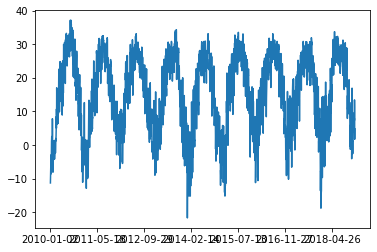

In [150]:
GFS_TMAX = daily_gfs_valid_time['TMAX']['2010-01-01 12:00:00':'2018-12-30 12:00:00']  # select 2010-01-01 to 2018-12-30
GFS_TMAX.index = GFS_TMAX.index.strftime('%Y-%m-%d')  # to be consistent with observation index
print(GFS_TMAX)
GFS_TMAX.plot()

Date
2010-01-02     6.0
2010-01-03    10.0
2010-01-04    11.0
2010-01-05    10.0
2010-01-06    18.0
              ... 
2018-12-26    45.0
2018-12-27    54.0
2018-12-28    51.0
2018-12-29    28.0
2018-12-30    36.0
Name: Max Hourly Temp (F), Length: 3261, dtype: float64


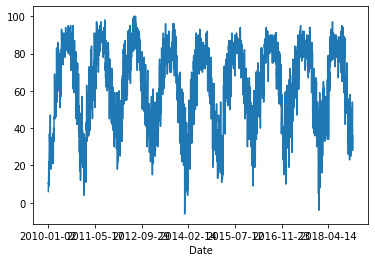

In [60]:
# Select 2010-01-02 to 2018-12-31 (one day after GFS model) and Mask Missing Data
mask_missing = daily_obs['Max Hourly Temp (F)'] == 'M'
OBS_TMAX = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_TMAX)
OBS_TMAX.plot()

### Delete missing days for GFS daily, GFS sfc, and Obs

<b>Find the overlap dates between GFS daily and observation (one day after GFS model)</b> and delete the missing dates.

In [0]:
# GFS_TMAX_plus1day = pd.to_datetime(GFS_TMAX.index) + pd.Timedelta('1 day')  # OBS dates are one day after GFS timestamps
# mismatch_dates = GFS_TMAX_plus1day.difference(pd.to_datetime(OBS_TMAX.index))  # OBS doesn't have these dates
# OBS_TMAX_dates = GFS_TMAX_plus1day.drop(mismatch_dates)  # dates derived from available GFS dates and OBS dates
# GFS_TMAX_dates = OBS_TMAX_dates - pd.Timedelta('1 day')

In [151]:
GFS_TMAX = daily_gfs_valid_time['TMAX']['2010-06-15':'2010-06-25']
GFS_TMAX

2010-06-15 06:00:00    27.14
2010-06-16 06:00:00    26.34
2010-06-17 06:00:00    28.34
2010-06-18 06:00:00    31.74
2010-06-19 06:00:00    32.74
2010-06-20 06:00:00    29.24
2010-06-22 06:00:00    33.24
2010-06-23 06:00:00    32.54
2010-06-24 06:00:00    26.54
2010-06-25 06:00:00    27.64
Name: TMAX, dtype: float64

In [155]:
idxall = pd.date_range('2010-06-15 06:00:00', '2010-06-25 06:00:00')
GFS_TMAX = GFS_TMAX.reindex(idxall)
GFS_TMAX

2010-06-15 06:00:00    27.14
2010-06-16 06:00:00    26.34
2010-06-17 06:00:00    28.34
2010-06-18 06:00:00    31.74
2010-06-19 06:00:00    32.74
2010-06-20 06:00:00    29.24
2010-06-21 06:00:00      NaN
2010-06-22 06:00:00    33.24
2010-06-23 06:00:00    32.54
2010-06-24 06:00:00    26.54
2010-06-25 06:00:00    27.64
Freq: D, Name: TMAX, dtype: float64

<b>Update the dates in both GFS and obs TMAX</b>

In [63]:
GFS_TMAX[GFS_TMAX_dates.strftime('%Y-%m-%d')]
OBS_TMAX[OBS_TMAX_dates.strftime('%Y-%m-%d')]

2010-01-02     6.0
2010-01-03    10.0
2010-01-04    11.0
2010-01-05    10.0
2010-01-06    18.0
              ... 
2018-12-26    45.0
2018-12-27    54.0
2018-12-28    51.0
2018-12-29    28.0
2018-12-30    36.0
Name: Max Hourly Temp (F), Length: 3225, dtype: float64

<b>Find the max temperature from sfc GFS dataset between 06Z to 06Z</b>

In [64]:
sfc_gfs.index = pd.to_datetime(sfc_gfs.index, format='%Y-%m-%d %H:%M:%S')
GFS_sfc_TMPC_daily_max = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
GFS_sfc_TMPC_daily_max

2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-27    13.44
2018-12-28    11.84
2018-12-29     1.64
2018-12-30     4.64
2018-12-31     4.64
Freq: D, Name: TMPC, Length: 3286, dtype: float64

<b> Drop the dates that don't exist </b>

In [65]:
mismatch_dates = pd.to_datetime(GFS_sfc_TMPC_daily_max.index).difference(pd.to_datetime(OBS_TMAX_dates))  # OBS_TMAX_dates doesn't have these dates
GFS_sfc_TMPC_max = GFS_sfc_TMPC_daily_max.drop(mismatch_dates)
GFS_sfc_TMPC_max

2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-26     7.24
2018-12-27    13.44
2018-12-28    11.84
2018-12-29     1.64
2018-12-30     4.64
Name: TMPC, Length: 3225, dtype: float64

## TMIN

### Plot the TMIN from GFS and observation

2010-01-01   -16.46
2010-01-02   -15.96
2010-01-03   -14.36
2010-01-04   -12.86
2010-01-05   -11.06
              ...  
2018-12-26     5.04
2018-12-27     0.04
2018-12-28    -2.66
2018-12-29    -3.16
2018-12-30     1.54
Name: TMIN, Length: 3249, dtype: float64


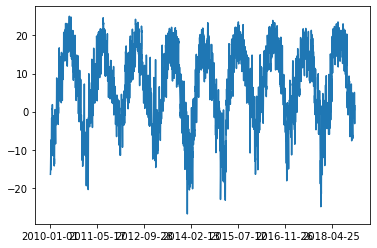

In [66]:
GFS_TMIN = daily_gfs['TMIN']['2010-01-01 12:00:00':'2018-12-30 12:00:00']  # select 2010-01-01 to 2018-12-30
GFS_TMIN.index = GFS_TMIN.index.strftime('%Y-%m-%d')  # to be consistent with observation index
print(GFS_TMIN)
GFS_TMIN.plot()

Date
2010-01-02    -5.0
2010-01-03    -6.0
2010-01-04    -2.0
2010-01-05    -1.0
2010-01-06    -3.0
              ... 
2018-12-26    24.0
2018-12-27    39.0
2018-12-28    28.0
2018-12-29    23.0
2018-12-30    18.0
Name: Min Hourly Temp (F), Length: 3261, dtype: float64


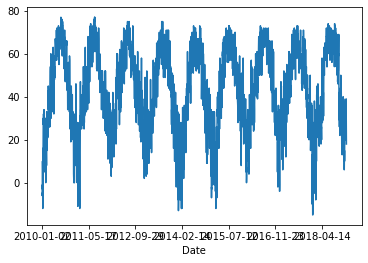

In [67]:
# Select 2010-01-02 to 2018-12-31 (one day after GFS model) and Mask Missing Data
mask_missing = daily_obs['Min Hourly Temp (F)'] == 'M'
OBS_TMIN = daily_obs['Min Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_TMIN)
OBS_TMIN.plot()

### Delete missing days for GFS daily, GFS sfc, and Obs

<b>Find the overlap dates between GFS daily and observation (one day after GFS model)</b> and delete the missing dates.

In [0]:
GFS_TMIN_plus1day = pd.to_datetime(GFS_TMIN.index) + pd.Timedelta('1 day')  # OBS dates are one day after GFS timestamps
mismatch_dates = GFS_TMIN_plus1day.difference(pd.to_datetime(OBS_TMIN.index))  # OBS doesn't have these dates
OBS_TMIN_dates = GFS_TMIN_plus1day.drop(mismatch_dates)  # dates derived from available GFS dates and OBS dates
GFS_TMIN_dates = OBS_TMIN_dates - pd.Timedelta('1 day')

<b>Update the dates in both GFS and obs TMAX</b>

In [69]:
GFS_TMIN[GFS_TMIN_dates.strftime('%Y-%m-%d')]
OBS_TMIN[OBS_TMIN_dates.strftime('%Y-%m-%d')]

2010-01-02    -5.0
2010-01-03    -6.0
2010-01-04    -2.0
2010-01-05    -1.0
2010-01-06    -3.0
              ... 
2018-12-26    24.0
2018-12-27    39.0
2018-12-28    28.0
2018-12-29    23.0
2018-12-30    18.0
Name: Min Hourly Temp (F), Length: 3225, dtype: float64

<b>Find the min temperature from sfc GFS dataset between 06Z to 06Z</b>

In [70]:
sfc_gfs.index = pd.to_datetime(sfc_gfs.index, format='%Y-%m-%d %H:%M:%S')
GFS_sfc_TMPC_daily_min = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).min()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
GFS_sfc_TMPC_daily_min

2010-01-02   -16.06
2010-01-03   -16.46
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.66
              ...  
2018-12-27     5.04
2018-12-28     0.84
2018-12-29    -2.26
2018-12-30    -3.06
2018-12-31     0.34
Freq: D, Name: TMPC, Length: 3286, dtype: float64

<b> Drop the dates that don't exist </b>

In [71]:
mismatch_dates = pd.to_datetime(GFS_sfc_TMPC_daily_min.index).difference(pd.to_datetime(OBS_TMIN_dates))  # OBS_TMAX_dates doesn't have these dates
GFS_sfc_TMPC_min = GFS_sfc_TMPC_daily_min.drop(mismatch_dates)
GFS_sfc_TMPC_min

2010-01-02   -16.06
2010-01-03   -16.46
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.66
              ...  
2018-12-26     0.54
2018-12-27     5.04
2018-12-28     0.84
2018-12-29    -2.26
2018-12-30    -3.06
Name: TMPC, Length: 3225, dtype: float64

## Max Wind

### Plot the WMAX from GFS and observation

2010-01-01     7.323933
2010-01-02     4.687217
2010-01-03     5.941380
2010-01-04     5.685068
2010-01-05     3.794733
                ...    
2018-12-26    10.288343
2018-12-27     7.990620
2018-12-28     5.001000
2018-12-29     6.580274
2018-12-30     8.139410
Name: WMAX, Length: 3249, dtype: float64


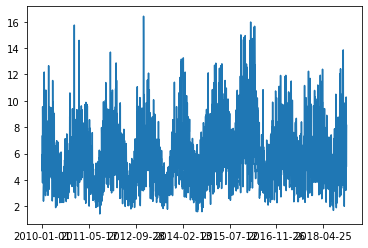

In [72]:
GFS_WMAX = daily_gfs['WMAX']['2010-01-01 12:00:00':'2018-12-30 12:00:00']  # select 2010-01-01 to 2018-12-30
GFS_WMAX.index = GFS_WMAX.index.strftime('%Y-%m-%d')  # to be consistent with observation index
print(GFS_WMAX)
GFS_WMAX.plot()

Date
2010-01-02    15.0
2010-01-03    11.0
2010-01-04    20.0
2010-01-05    16.0
2010-01-06     8.0
              ... 
2018-12-26    15.0
2018-12-27    33.0
2018-12-28    23.0
2018-12-29    16.0
2018-12-30    21.0
Name: Max Wind Speed (mph), Length: 3264, dtype: float64


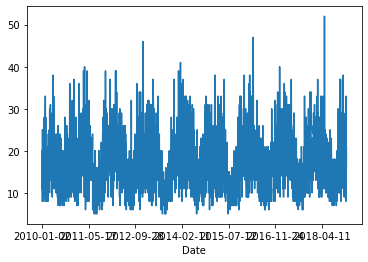

In [73]:
# Select 2010-01-02 to 2018-12-31 (one day after GFS model) and Mask Missing Data
mask_missing = daily_obs['Max Wind Speed (mph)'] == 'M'
OBS_WMAX = daily_obs['Max Wind Speed (mph)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_WMAX)
OBS_WMAX.plot()

### Delete missing days for GFS daily, GFS sfc, and Obs

<b>Find the overlap dates between GFS daily and observation (one day after GFS model)</b> and delete the missing dates.

In [0]:
GFS_WMAX_plus1day = pd.to_datetime(GFS_WMAX.index) + pd.Timedelta('1 day')  # OBS dates are one day after GFS timestamps
mismatch_dates = GFS_WMAX_plus1day.difference(pd.to_datetime(OBS_WMAX.index))  # OBS doesn't have these dates
OBS_WMAX_dates = GFS_WMAX_plus1day.drop(mismatch_dates)  # dates derived from available GFS dates and OBS dates
GFS_WMAX_dates = OBS_WMAX_dates - pd.Timedelta('1 day')

<b>Update the dates in both GFS and obs TMAX</b>

In [75]:
GFS_WMAX[GFS_WMAX_dates.strftime('%Y-%m-%d')]
OBS_WMAX[OBS_WMAX_dates.strftime('%Y-%m-%d')]

2010-01-02    15.0
2010-01-03    11.0
2010-01-04    20.0
2010-01-05    16.0
2010-01-06     8.0
              ... 
2018-12-26    15.0
2018-12-27    33.0
2018-12-28    23.0
2018-12-29    16.0
2018-12-30    21.0
Name: Max Wind Speed (mph), Length: 3227, dtype: float64

<b>Find the max wind from sfc GFS dataset between 06Z to 06Z</b>

In [76]:
sfc_gfs.index = pd.to_datetime(sfc_gfs.index, format='%Y-%m-%d %H:%M:%S')
GFS_sfc_WMAX_daily = sfc_gfs['WSPD'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
GFS_sfc_WMAX_daily

2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-27    10.288343
2018-12-28     7.963040
2018-12-29     5.186521
2018-12-30     6.440497
2018-12-31     6.332456
Freq: D, Name: WSPD, Length: 3286, dtype: float64

<b> Drop the dates that don't exist </b>

In [77]:
mismatch_dates = pd.to_datetime(GFS_sfc_WMAX_daily.index).difference(pd.to_datetime(OBS_WMAX_dates))  # OBS_TMAX_dates doesn't have these dates
GFS_sfc_WMAX = GFS_sfc_WMAX_daily.drop(mismatch_dates)
GFS_sfc_WMAX

2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-26     6.161169
2018-12-27    10.288343
2018-12-28     7.963040
2018-12-29     5.186521
2018-12-30     6.440497
Name: WSPD, Length: 3227, dtype: float64

**bold text** ## Precipitation

### Plot the WMAX from GFS and observation

2010-01-01     0.05
2010-01-02     0.00
2010-01-03     0.06
2010-01-04     0.17
2010-01-05     0.77
              ...  
2018-12-26     9.94
2018-12-27     0.18
2018-12-28     0.00
2018-12-29     0.00
2018-12-30    29.71
Name: RTOT, Length: 3249, dtype: float64


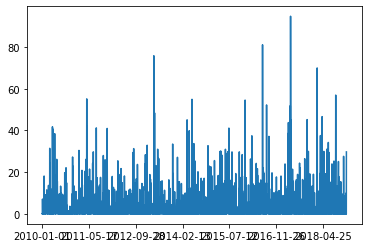

In [78]:
daily_gfs[daily_gfs['RTOT'] < 0] = 0 # Takes care of trace precip
GFS_PRCP = daily_gfs['RTOT']['2010-01-01 12:00:00':'2018-12-30 12:00:00']  # select 2010-01-01 to 2018-12-30
GFS_PRCP.index = GFS_PRCP.index.strftime('%Y-%m-%d')  # to be consistent with observation index
print(GFS_PRCP)
GFS_PRCP.plot()

Date
2010-01-02     0.0
2010-01-03     0.0
2010-01-04     0.0
2010-01-05     0.0
2010-01-06     5.6
              ... 
2018-12-27    13.9
2018-12-28     0.0
2018-12-29     0.0
2018-12-30     9.0
2018-12-31    27.4
Name: Total Precip from Hourly (in), Length: 3286, dtype: float64


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


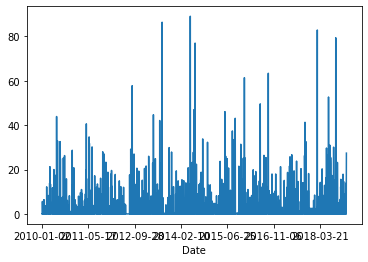

In [79]:
# Select 2010-01-02 to 2018-12-31 (one day after GFS model) and Mask Missing Data
mask_missing = daily_obs['Total Precip from Hourly (in)'] == 'M'
OBS_PRCP = daily_obs['Total Precip from Hourly (in)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_PRCP)
OBS_PRCP.plot()

### Delete missing days for GFS daily, GFS sfc, and Obs

<b>Find the overlap dates between GFS daily and observation (one day after GFS model)</b> and delete the missing dates.

In [0]:
GFS_PRCP_plus1day = pd.to_datetime(GFS_PRCP.index) + pd.Timedelta('1 day')  # OBS dates are one day after GFS timestamps
mismatch_dates = GFS_PRCP_plus1day.difference(pd.to_datetime(OBS_PRCP.index))  # OBS doesn't have these dates
OBS_PRCP_dates = GFS_PRCP_plus1day.drop(mismatch_dates)  # dates derived from available GFS dates and OBS dates
GFS_PRCP_dates = OBS_PRCP_dates - pd.Timedelta('1 day')

<b>Update the dates in both GFS and obs TMAX</b>

In [81]:
GFS_PRCP[GFS_PRCP_dates.strftime('%Y-%m-%d')]
OBS_PRCP[OBS_PRCP_dates.strftime('%Y-%m-%d')]

2010-01-02     0.0
2010-01-03     0.0
2010-01-04     0.0
2010-01-05     0.0
2010-01-06     5.6
              ... 
2018-12-27    13.9
2018-12-28     0.0
2018-12-29     0.0
2018-12-30     9.0
2018-12-31    27.4
Name: Total Precip from Hourly (in), Length: 3249, dtype: float64

<b>Find the total precip from sfc GFS dataset between 06Z to 06Z</b>

In [82]:
sfc_gfs.index = pd.to_datetime(sfc_gfs.index, format='%Y-%m-%d %H:%M:%S')
sfc_gfs[sfc_gfs['PRCP'] < 0] = 0 # Takes care of trace precip
GFS_sfc_PRCP_daily = sfc_gfs['PRCP'].astype(float).resample('24H',base=6).sum()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
GFS_sfc_PRCP_daily

2010-01-02     0.05
2010-01-03     0.00
2010-01-04     0.03
2010-01-05     0.20
2010-01-06     0.11
              ...  
2018-12-27     9.97
2018-12-28     0.15
2018-12-29     0.03
2018-12-30     0.00
2018-12-31    29.63
Freq: D, Name: PRCP, Length: 3286, dtype: float64

<b> Drop the dates that don't exist </b>

In [83]:
mismatch_dates = pd.to_datetime(GFS_sfc_PRCP_daily.index).difference(pd.to_datetime(OBS_PRCP_dates))  # OBS_TMAX_dates doesn't have these dates
GFS_sfc_PRCP = GFS_sfc_PRCP_daily.drop(mismatch_dates)
GFS_sfc_PRCP

2010-01-02     0.05
2010-01-03     0.00
2010-01-04     0.03
2010-01-05     0.20
2010-01-06     0.11
              ...  
2018-12-27     9.97
2018-12-28     0.15
2018-12-29     0.03
2018-12-30     0.00
2018-12-31    29.63
Name: PRCP, Length: 3249, dtype: float64

# Linear regression model


## TMAX

Model slope:     [0.81910761 0.25291388]
Model intercept: 0.0


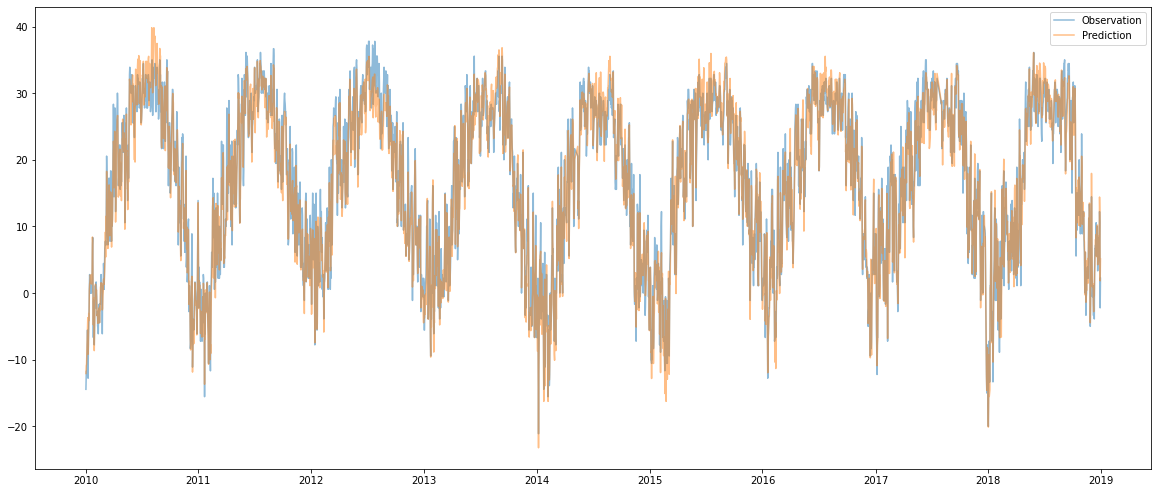

RMS:  2.243860346972388


In [84]:
X = np.column_stack((GFS_TMAX[GFS_TMAX_dates.strftime('%Y-%m-%d')].values, GFS_sfc_TMPC_max.values))  # GFS model daily and sfc max TMPC
y = (OBS_TMAX[OBS_TMAX_dates.strftime('%Y-%m-%d')].values-32)*5/9  # Observation, converted from F to C

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_predict = model.predict(X)  # linear regression model prediction

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMAX_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## TMIN

Model slope:     [0.87602057 0.13003458]
Model intercept: 0.0


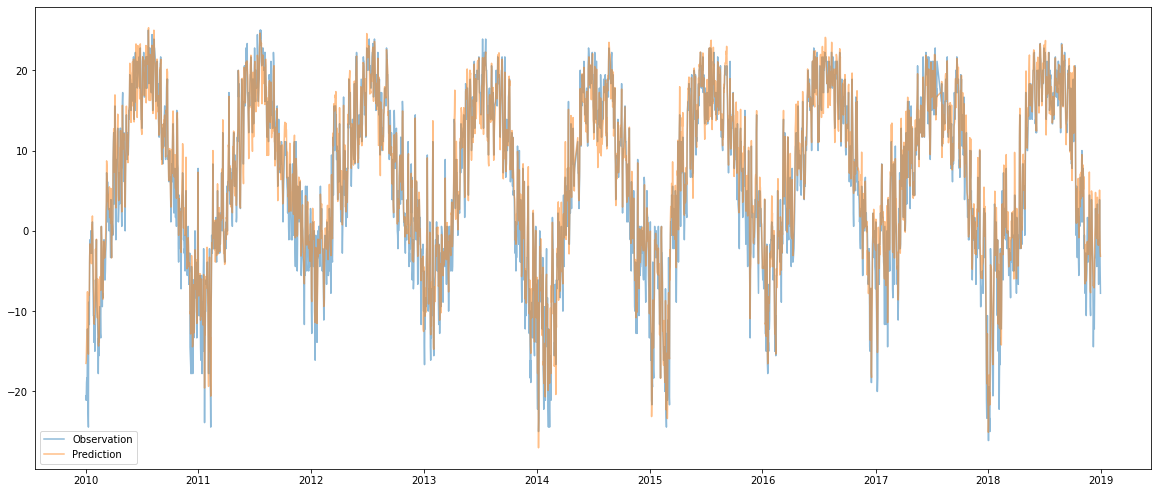

RMS:  2.146277443997052


In [85]:
X = np.column_stack((GFS_TMIN[GFS_TMIN_dates.strftime('%Y-%m-%d')].values, GFS_sfc_TMPC_min.values))  # GFS model daily and sfc min TMPC
y = (OBS_TMIN[OBS_TMIN_dates.strftime('%Y-%m-%d')].values-32)*5/9  # Observation, converted from F to C

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_predict = model.predict(X)  # linear regression model prediction

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMIN_dates, X, alpha=0.5)
plt.plot(OBS_TMIN_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## Max Wind

Model slope:     [0.89309483 0.39048531]
Model intercept: 0.0


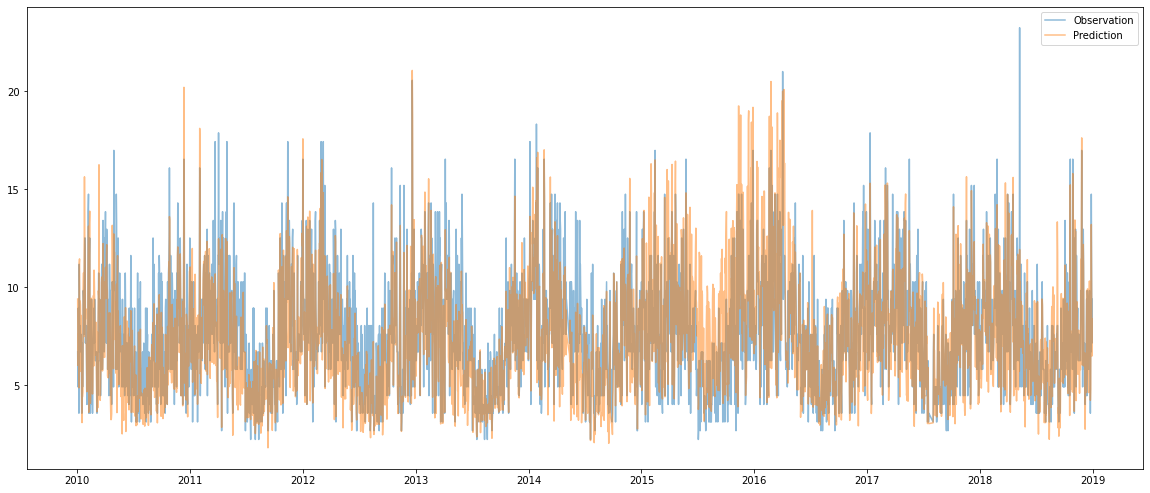

RMS:  1.7926311454029


In [86]:
X = np.column_stack((GFS_WMAX[GFS_WMAX_dates.strftime('%Y-%m-%d')].values, GFS_sfc_WMAX.values))  # GFS model daily and sfc WMAX
y = (OBS_WMAX[OBS_WMAX_dates.strftime('%Y-%m-%d')].values)*0.44704  # Observation, converted from mph to m/s

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_predict = model.predict(X)  # linear regression model prediction

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_WMAX_dates, X, alpha=0.5)
plt.plot(OBS_WMAX_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## Precipitation

Model slope:     [ 0.03007177 -0.01040771]
Model intercept: 0.0


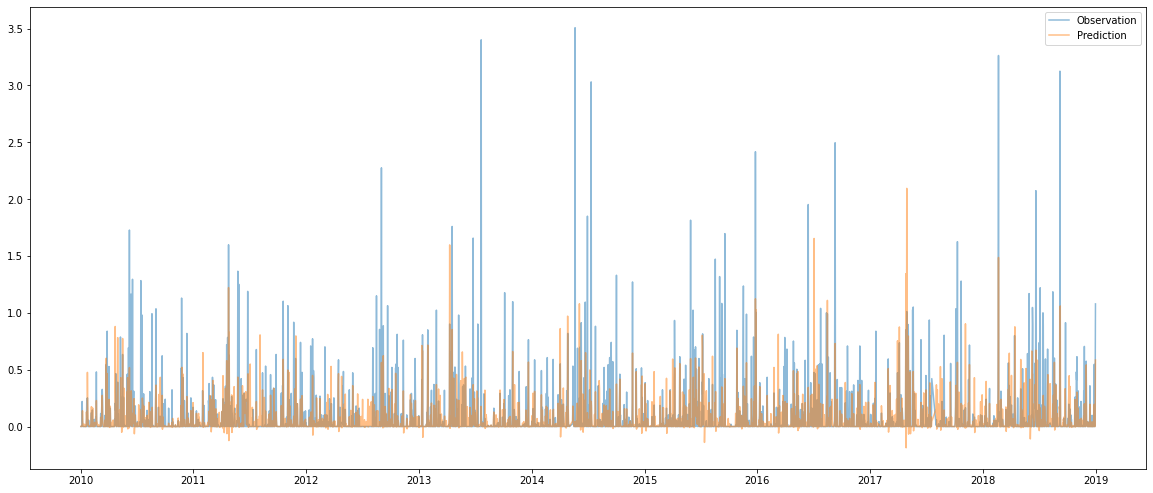

RMS:  0.22025242814220636


In [87]:
X = np.column_stack((GFS_PRCP[GFS_PRCP_dates.strftime('%Y-%m-%d')].values, GFS_sfc_PRCP.values))  # GFS model daily and sfc total PRCP
y = (OBS_PRCP[OBS_PRCP_dates.strftime('%Y-%m-%d')].values)*0.039370  # Observation, converted from mm to inches

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_predict = model.predict(X)  # linear regression model prediction

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_PRCP_dates, X, alpha=0.5)
plt.plot(OBS_PRCP_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

# Random forest regression model

## TMAX

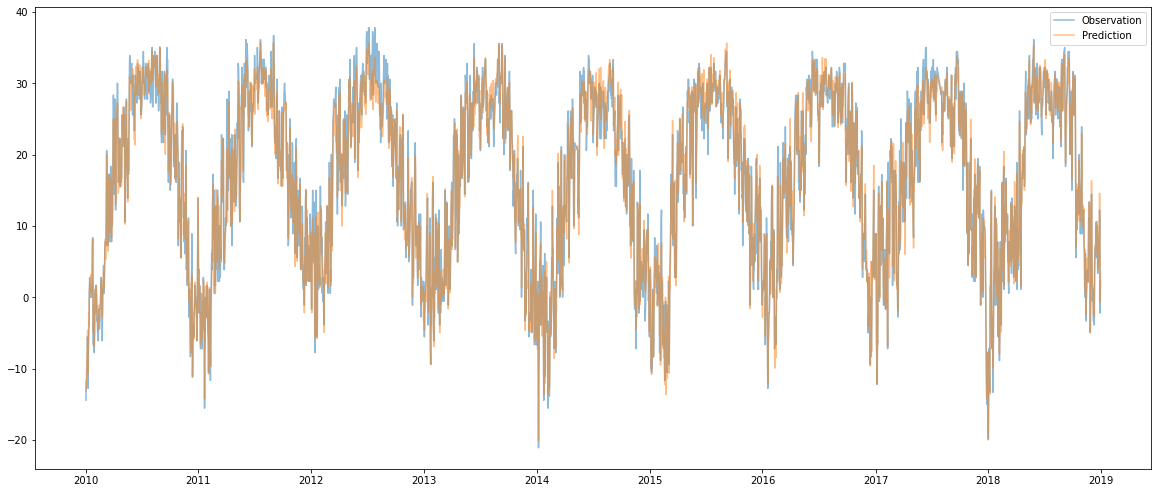

RMS:  1.8761024294446025


In [88]:
X = np.column_stack((GFS_TMAX[GFS_TMAX_dates.strftime('%Y-%m-%d')].values, GFS_sfc_TMPC_max.values))  # GFS model daily and sfc max TMPC
y = (OBS_TMAX[OBS_TMAX_dates.strftime('%Y-%m-%d')].values-32)*5/9  # Observation, converted from F to C

forest = RandomForestRegressor(200)
forest.fit(X, y)
y_predict = forest.predict(X)

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMAX_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## TMIN

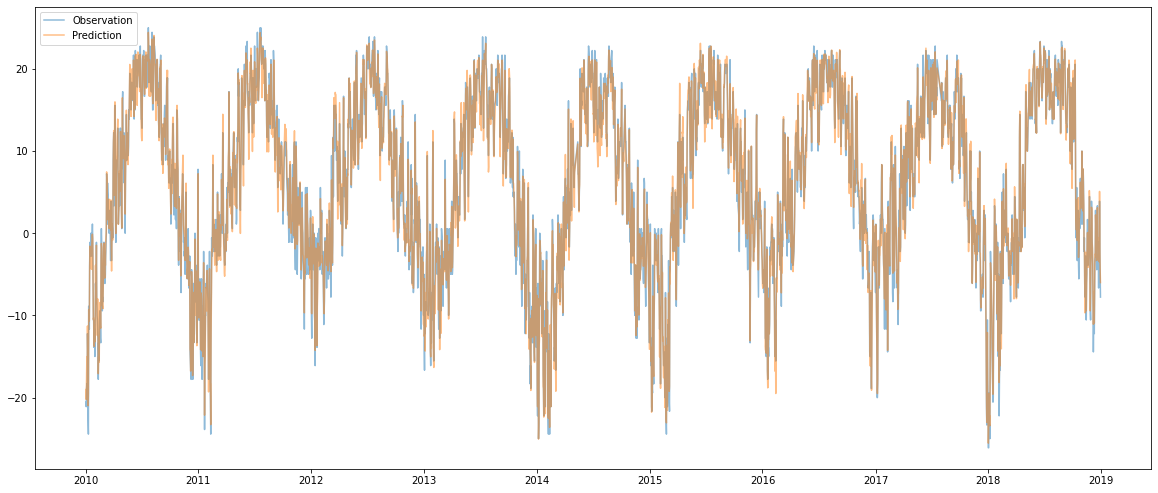

RMS:  1.348707994761678


In [89]:
X = np.column_stack((GFS_TMIN[GFS_TMIN_dates.strftime('%Y-%m-%d')].values, GFS_sfc_TMPC_min.values))  # GFS model daily and sfc min TMPC
y = (OBS_TMIN[OBS_TMIN_dates.strftime('%Y-%m-%d')].values-32)*5/9  # Observation, converted from F to C

forest = RandomForestRegressor(200)
forest.fit(X, y)
y_predict = forest.predict(X)

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMIN_dates, X, alpha=0.5)
plt.plot(OBS_TMIN_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## Max Wind

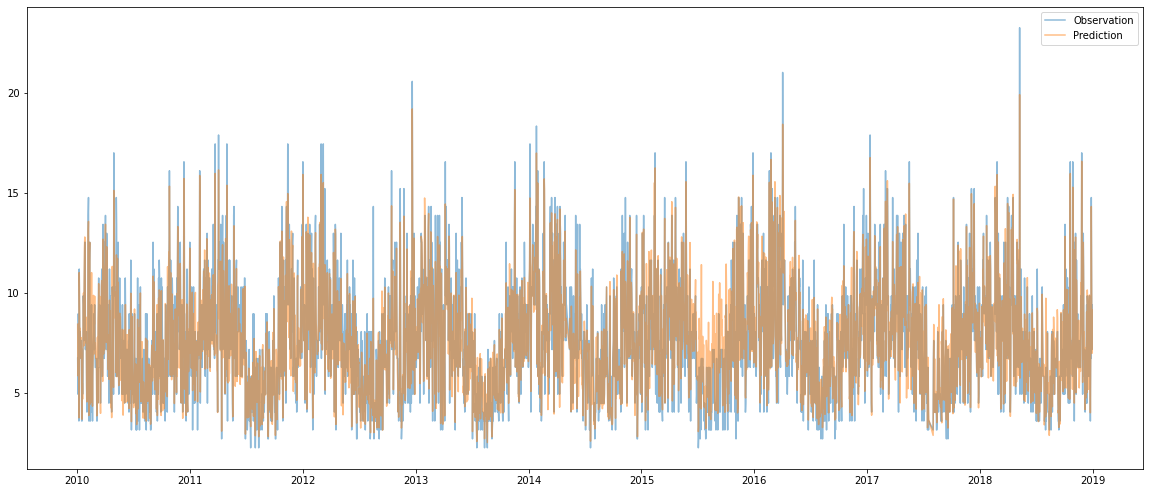

RMS:  0.9807488281777973


In [90]:
X = np.column_stack((GFS_WMAX[GFS_WMAX_dates.strftime('%Y-%m-%d')].values, GFS_sfc_WMAX.values))  # GFS model daily and sfc WMAX
y = (OBS_WMAX[OBS_WMAX_dates.strftime('%Y-%m-%d')].values)*0.44704  # Observation, converted from mph to m/s

forest = RandomForestRegressor(200)
forest.fit(X, y)
y_predict = forest.predict(X)

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_WMAX_dates, X, alpha=0.5)
plt.plot(OBS_WMAX_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)

## Precipitation

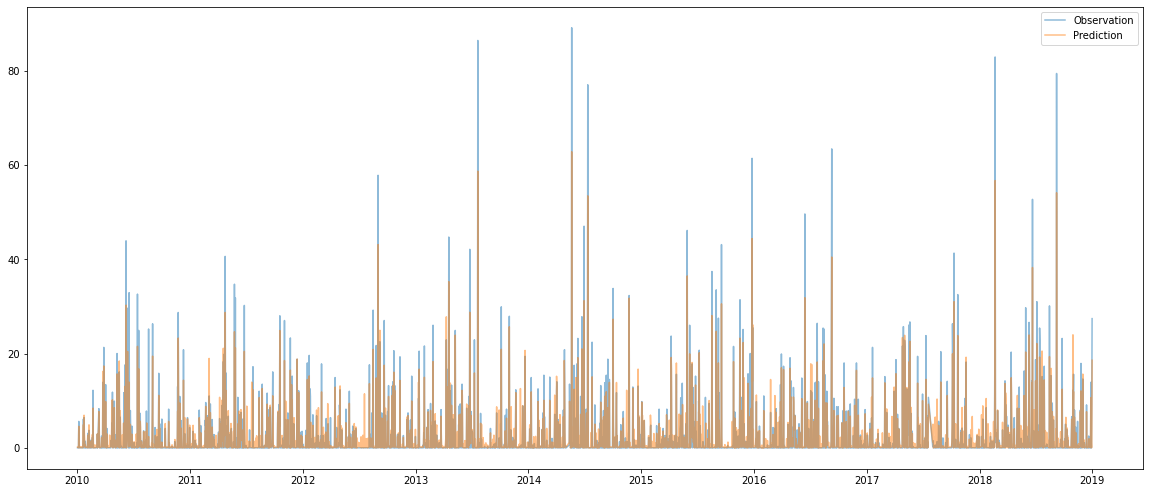

RMS:  2.4582164811221494


In [91]:
X = np.column_stack((GFS_PRCP[GFS_PRCP_dates.strftime('%Y-%m-%d')].values, GFS_sfc_PRCP.values))  # GFS model daily and sfc total PRCP
y = (OBS_PRCP[OBS_PRCP_dates.strftime('%Y-%m-%d')].values)

forest = RandomForestRegressor(200)
forest.fit(X, y)
y_predict = forest.predict(X)

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_PRCP_dates, X, alpha=0.5)
plt.plot(OBS_PRCP_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms = sqrt(mean_squared_error(y, y_predict))
print('RMS: ', rms)